# Detection

In [5]:
# Todo
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import matplotlib.patches as patches


### Load data and preprocessing

In [6]:
SEED = 265
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inngangsbildestørrelse og grid-dimensjoner
H_in, W_in = 48, 60  # Bildestørrelse
H_out, W_out = 2, 3   # Grid: 2 rader og 3 kolonner

# Last inn data (bilder og labels)
imgs_train = torch.load("data/detection_train.pt")
imgs_val   = torch.load("data/detection_val.pt")
imgs_test  = torch.load("data/detection_test.pt")

# Ekstraher bildene fra tuple-dataene og stable dem
train_images = torch.stack([img for img, _ in imgs_train])
val_images   = torch.stack([img for img, _ in imgs_val])
test_images  = torch.stack([img for img, _ in imgs_test])

# Sjekk om bildedataene mangler kanal-dimensjon; legg til hvis nødvendig
if train_images.dim() == 3:
    train_images = train_images.unsqueeze(1)
if val_images.dim() == 3:
    val_images = val_images.unsqueeze(1)
if test_images.dim() == 3:
    test_images = test_images.unsqueeze(1)

# Last inn uprosesserte labels (liste med lister med tensorer: [pc, x, y, w, h, c])
y_true_train = torch.load("data/list_y_true_train.pt")
y_true_val   = torch.load("data/list_y_true_val.pt")
y_true_test  = torch.load("data/list_y_true_test.pt")

# Funksjon for å konvertere labels til grid-format (N, H_out, W_out, 6)
def convert_to_grid(y_true_list, H_out=2, W_out=3, img_h=48, img_w=60):
    N = len(y_true_list)
    y_true_grid = torch.zeros((N, H_out, W_out, 6))
    for img_idx, objects in enumerate(y_true_list):
        for obj in objects:
            pc, x, y, w, h, c = obj
            grid_h = int(y * H_out)
            grid_w = int(x * W_out)
            # Beregn lokale koordinater i grid-cellen
            x_local = (x - (grid_w / W_out)) * W_out
            y_local = (y - (grid_h / H_out)) * H_out
            w_local = w * W_out
            h_local = h * H_out
            y_true_grid[img_idx, grid_h, grid_w] = torch.tensor([1, x_local, y_local, w_local, h_local, c])
    return y_true_grid

# Konverter labels til grid-format
labels_train = convert_to_grid(y_true_train, H_out, W_out, H_in, W_in)
labels_val   = convert_to_grid(y_true_val, H_out, W_out, H_in, W_in)
labels_test  = convert_to_grid(y_true_test, H_out, W_out, H_in, W_in)

# Opprett TensorDatasets og DataLoaders
train_dataset = TensorDataset(train_images, labels_train)
val_dataset   = TensorDataset(val_images, labels_val)
test_dataset  = TensorDataset(test_images, labels_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test utskrift
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: torch.Size([32, 1, 48, 60]), Labels shape: torch.Size([32, 2, 3, 6])


### Normalize Images

In [7]:

mean = train_images.mean()
std = train_images.std()
normalize_transform = transforms.Normalize(mean, std)

# Normaliser alle bildedataene
train_images = normalize_transform(train_images)
val_images   = normalize_transform(val_images)
test_images  = normalize_transform(test_images)

In [8]:

class DetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(DetectNet, self).__init__()
        self.num_classes = num_classes
        self.out_channels = num_classes + 5  # (pc, x, y, w, h, c)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.conv_out = nn.Conv2d(64, self.out_channels, kernel_size=3, padding=0)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x

class DetectNetSmall(nn.Module):
    def __init__(self):
        super(DetectNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # (48,60) -> (24,30)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # (24,30) -> (12,15)
        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))  # (12,15) -> (2,3)
        self.conv_out = nn.Conv2d(16, 7, 1)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x

class DetectNetLarger(nn.Module):
    def __init__(self):
        super(DetectNetLarger, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))
        self.conv_out = nn.Conv2d(64, 7, 1)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.conv_out(x)
        return x
class ImprovedDetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(ImprovedDetectNet, self).__init__()
        self.num_classes = num_classes
        self.out_channels = num_classes + 5
        # Økte antall filtre for bedre representasjon
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.conv_out = nn.Conv2d(128, self.out_channels, kernel_size=3, padding=0)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x


### Training

In [9]:
def detection_loss(y_pred, y_true):
    y_pred = y_pred.permute(0, 2, 3, 1)  # Endre dimensjoner til (N, H_out, W_out, C+5)
    loss_pc = nn.BCEWithLogitsLoss()(y_pred[:, :, :, 0], y_true[:, :, :, 0])
    loss_bbox = torch.where(
        y_true[:, :, :, 0] == 1,
        nn.MSELoss(reduction='none')(y_pred[:, :, :, 1:5], y_true[:, :, :, 1:5]).mean(dim=-1),
        torch.zeros_like(y_true[:, :, :, 0])
    ).mean()
    mask = y_true[:, :, :, 0] == 1
    pred_classes = y_pred[:, :, :, 5:][mask]
    true_classes = y_true[:, :, :, -1][mask].long()
    if pred_classes.shape[0] > 0:
        loss_class = nn.CrossEntropyLoss()(pred_classes, true_classes)
    else:
        loss_class = torch.tensor(0.0, device=y_pred.device)
    return loss_pc + loss_bbox + loss_class

def train_detection_model(model, train_loader, val_loader, optimizer, num_epochs=10, early_stop_patience=7):
    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            preds = model(images)
            loss = detection_loss(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                preds = model(images)
                val_loss += detection_loss(preds, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

### Prediction

In [10]:

def plot_predictions(model, loader, num_images=5):
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    model.eval()
    images, labels = next(iter(loader))
    preds = model(images.to(DEVICE)).cpu().detach()
    preds = preds.permute(0, 2, 3, 1)  # (N, H_out, W_out, C+5)
    for i in range(num_images):
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")
        for h in range(H_out):
            for w in range(W_out):
                if labels[i, h, w, 0].item() == 0:
                    continue
                true_bb = labels[i, h, w, 1:5].cpu().numpy()
                pred_bb = preds[i, h, w, 1:5].cpu().numpy()
                plt.gca().add_patch(plt.Rectangle(
                    (true_bb[0] * W_in - true_bb[2] * W_in / 2, true_bb[1] * H_in - true_bb[3] * H_in / 2),
                    true_bb[2] * W_in, true_bb[3] * H_in,
                    edgecolor='green', linewidth=2, fill=False))
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bb[0] * W_in - pred_bb[2] * W_in / 2, pred_bb[1] * H_in - pred_bb[3] * H_in / 2),
                    pred_bb[2] * W_in, pred_bb[3] * H_in,
                    edgecolor='red', linewidth=2, fill=False))
        plt.show()


### Model selection and evaluation

In [11]:
def IoU(box1, box2):
    """
    Beregn Intersection over Union (IoU) for to bounding boxes.
    Hver boks er definert som [x, y, w, h], der (x, y) er senterkoordinat.
    """
    # Konverter fra senter-koordinater til hjørner
    box1_x1 = box1[0] - box1[2] / 2
    box1_y1 = box1[1] - box1[3] / 2
    box1_x2 = box1[0] + box1[2] / 2
    box1_y2 = box1[1] + box1[3] / 2

    box2_x1 = box2[0] - box2[2] / 2
    box2_y1 = box2[1] - box2[3] / 2
    box2_x2 = box2[0] + box2[2] / 2
    box2_y2 = box2[1] + box2[3] / 2

    # Finn skjæringsområdet
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    if inter_x2 < inter_x1 or inter_y2 < inter_y1:
        return 0.0

    intersection = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    union = (box1[2] * box1[3]) + (box2[2] * box2[3]) - intersection
    return intersection / union if union > 0 else 0.0

def compute_IoU_detection(model, loader, preprocessor=None):
    model.eval()
    total_iou = 0
    count = 0
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)
            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            iou = IoU(preds[i, h, w, 1:5].cpu().numpy(), labels[i, h, w, 1:5].cpu().numpy())
                            total_iou += iou
                            count += 1
    avg_iou = total_iou / count if count > 0 else 0
    print(f"Average IoU: {avg_iou:.4f}")
    return avg_iou

def compute_accuracy_detection(model, loader, preprocessor=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)
            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            pred_class = preds[i, h, w, 5:].argmax().item()
                            true_class = labels[i, h, w, -1].item()
                            if pred_class == true_class:
                                correct += 1
                            total += 1
    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

def plot_images_with_bboxes(model, dataset, indices=None, num_images=5):
    
    model.eval()
    
    # Define class names (assuming 2 classes)
    class_names = [f"Class {i}" for i in range(2)]
    
    # Select indices to plot
    if indices is None:
        indices = random.sample(range(len(dataset)), num_images)
    else:
        # Ensure we don't exceed the length of the dataset
        indices = indices[:min(len(indices), len(dataset))]
        num_images = len(indices)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    if num_images == 1:
        axes = [axes]  # Make it iterable if there is only one subplot
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Normalize image if needed
        norm_image = image.clone()
        
        # Forward pass
        norm_image = norm_image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(norm_image)
        
        # Extract predictions
        preds = output.permute(0, 2, 3, 1)[0].cpu()
        
        # Convert image to numpy for display
        display_img = image.squeeze().cpu().numpy()
        
        # Plot the image
        ax = axes[i]
        ax.imshow(display_img, cmap='gray')
        ax.set_title(f"Image {idx}")
        
        # Calculate image dimensions
        height, width = display_img.shape
        
        # Convert normalized bbox coordinates to pixel coordinates
        def bbox_to_pixels(bbox, cell_w, cell_h, cell_x, cell_y):
            x, y, w, h = bbox
            # Convert to top-left format for Rectangle patch
            x_min = max(0, (cell_x + x * cell_w - w * W_in / 2))
            y_min = max(0, (cell_y + y * cell_h - h * H_in / 2))
            w_px = min(w * W_in, width - x_min)
            h_px = min(h * H_in, height - y_min)
            return x_min, y_min, w_px, h_px
        
        # Draw true and predicted bounding boxes
        for h in range(H_out):
            for w in range(W_out):
                if label[h, w, 0].item() < 0.5:
                    continue
                
                # True bounding box
                true_bb = label[h, w, 1:5].cpu().numpy()
                cell_w = W_in / W_out
                cell_h = H_in / H_out
                cell_x = w * cell_w
                cell_y = h * cell_h
                
                x_min, y_min, w_px, h_px = bbox_to_pixels(true_bb, cell_w, cell_h, cell_x, cell_y)
                true_rect = patches.Rectangle(
                    (x_min, y_min), w_px, h_px,
                    linewidth=2, edgecolor='g', facecolor='none'
                )
                ax.add_patch(true_rect)
                ax.text(
                    x_min, y_min - 5, 
                    f'True: {class_names[int(label[h, w, -1].item())]}', 
                    color='white', fontsize=10, 
                    bbox=dict(facecolor='green', alpha=0.7, pad=1))
                
                # Predicted bounding box
                pred_bb = preds[h, w, 1:5].numpy()
                x_min, y_min, w_px, h_px = bbox_to_pixels(pred_bb, cell_w, cell_h, cell_x, cell_y)
                pred_rect = patches.Rectangle(
                    (x_min, y_min), w_px, h_px,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(pred_rect)
                ax.text(
                    x_min, max(0, y_min - 20), 
                    f'Pred: {class_names[int(preds[h, w, 5:].argmax().item())]}', 
                    color='white', fontsize=10, 
                    bbox=dict(facecolor='red', alpha=0.7, pad=1))
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    return fig
        
def find_best_and_worst_predictions(model, dataset, n_samples=5):
    """
    Find examples of the best and worst predictions based on IoU scores.
    
    """
    model.eval()
    results = []
    
    # Define IoU function
    def compute_single_iou(bb1, bb2):
        # Convert from center format to corner format
        bb1_x1 = bb1[0] - bb1[2]/2
        bb1_y1 = bb1[1] - bb1[3]/2
        bb1_x2 = bb1[0] + bb1[2]/2
        bb1_y2 = bb1[1] + bb1[3]/2
        
        bb2_x1 = bb2[0] - bb2[2]/2
        bb2_y1 = bb2[1] - bb2[3]/2
        bb2_x2 = bb2[0] + bb2[2]/2
        bb2_y2 = bb2[1] + bb2[3]/2
        
        # Calculate intersection coordinates
        x1 = max(bb1_x1, bb2_x1)
        y1 = max(bb1_y1, bb2_y1)
        x2 = min(bb1_x2, bb2_x2)
        y2 = min(bb1_y2, bb2_y2)
        
        # Check if there is an intersection
        if x2 < x1 or y2 < y1:
            return 0.0
        
        # Calculate intersection area
        intersection_area = (x2 - x1) * (y2 - y1)
        
        # Calculate union area
        bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
        bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)
        union_area = bb1_area + bb2_area - intersection_area
        
        # Calculate IoU
        if union_area < 1e-5:
            return 0.0
        return intersection_area / union_area
    
    # Evaluate each sample
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Forward pass
        image_input = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            preds = model(image_input)
        preds = preds.permute(0, 2, 3, 1)[0].cpu()
        
        total_iou = 0.0
        count = 0
        for h in range(H_out):
            for w in range(W_out):
                if label[h, w, 0].item() < 0.5:
                    continue
                
                true_bb = label[h, w, 1:5].cpu().numpy()
                pred_bb = preds[h, w, 1:5].numpy()
                
                cell_w = W_in / W_out
                cell_h = H_in / H_out
                cell_x = w * cell_w
                cell_y = h * cell_h
                
                true_center = [cell_x + true_bb[0] * cell_w, cell_y + true_bb[1] * cell_h]
                true_box = [true_center[0], true_center[1], true_bb[2] * W_in, true_bb[3] * H_in]
                
                pred_center = [cell_x + pred_bb[0] * cell_w, cell_y + pred_bb[1] * cell_h]
                pred_box = [pred_center[0], pred_center[1], pred_bb[2] * W_in, pred_bb[3] * H_in]
                
                iou_val = compute_single_iou(pred_box, true_box)
                total_iou += iou_val
                count += 1
        
        avg_iou = total_iou / count if count > 0 else 0.0
        results.append((idx, avg_iou))
    
    # Sort results by IoU
    results.sort(key=lambda x: x[1])
    
    # Get worst predictions (lowest IoU)
    worst_indices = [x[0] for x in results[:n_samples]]
    
    # Get best predictions (highest IoU)
    best_indices = [x[0] for x in results[-n_samples:]][::-1]
    
    return best_indices, worst_indices


### Main Execution

In [12]:
# Trening av flere modeller, inkludert improved_model
model_classes = [DetectNetSmall, DetectNet, DetectNetLarger,ImprovedDetectNet]
trained_models = []
for model_class in model_classes:
    print(f"\nTraining {model_class.__name__} with hyperparameters")
    temp_model = model_class().to(DEVICE)
    optimizer = optim.Adam(temp_model.parameters(), lr=0.001, weight_decay=0.0001)
    train_detection_model(temp_model, train_loader, val_loader, optimizer)
    iou_val = compute_IoU_detection(temp_model, test_loader)
    acc_val = compute_accuracy_detection(temp_model, test_loader)
    trained_models.append({
        "model": temp_model,
        "model_name": model_class.__name__,
        "iou": iou_val,
        "accuracy": acc_val
    })

print("\n===== MODEL COMPARISON =====")
for model_info in trained_models:
    print(f"Model: {model_info['model_name']}")
    print(f"  IoU: {model_info['iou']:.4f}")
    print(f"  Accuracy: {model_info['accuracy']:.4f}")

# Velg den modellen med høyest IoU som best_model (kan kombineres med accuracy om ønskelig)
best_model = max(trained_models, key=lambda x: x["iou"])["model"]



Training DetectNetSmall with hyperparameters
Epoch 1/10 | Train Loss: 0.7084 | Val Loss: 0.4496
Epoch 2/10 | Train Loss: 0.4162 | Val Loss: 0.3766
Epoch 3/10 | Train Loss: 0.3537 | Val Loss: 0.3330
Epoch 4/10 | Train Loss: 0.3270 | Val Loss: 0.3119
Epoch 5/10 | Train Loss: 0.3101 | Val Loss: 0.3041
Epoch 6/10 | Train Loss: 0.2979 | Val Loss: 0.2859
Epoch 7/10 | Train Loss: 0.2890 | Val Loss: 0.2827
Epoch 8/10 | Train Loss: 0.2821 | Val Loss: 0.2765
Epoch 9/10 | Train Loss: 0.2774 | Val Loss: 0.2732
Epoch 10/10 | Train Loss: 0.2720 | Val Loss: 0.2755
Average IoU: 0.2821
Accuracy: 0.9805

Training DetectNet with hyperparameters
Epoch 1/10 | Train Loss: 0.4352 | Val Loss: 0.2519
Epoch 2/10 | Train Loss: 0.2099 | Val Loss: 0.1822
Epoch 3/10 | Train Loss: 0.1686 | Val Loss: 0.1554
Epoch 4/10 | Train Loss: 0.1425 | Val Loss: 0.1301
Epoch 5/10 | Train Loss: 0.1258 | Val Loss: 0.1197
Epoch 6/10 | Train Loss: 0.1155 | Val Loss: 0.1164
Epoch 7/10 | Train Loss: 0.1059 | Val Loss: 0.1104
Epoch 8/

### Predition 

Visualizing random test samples with best model....


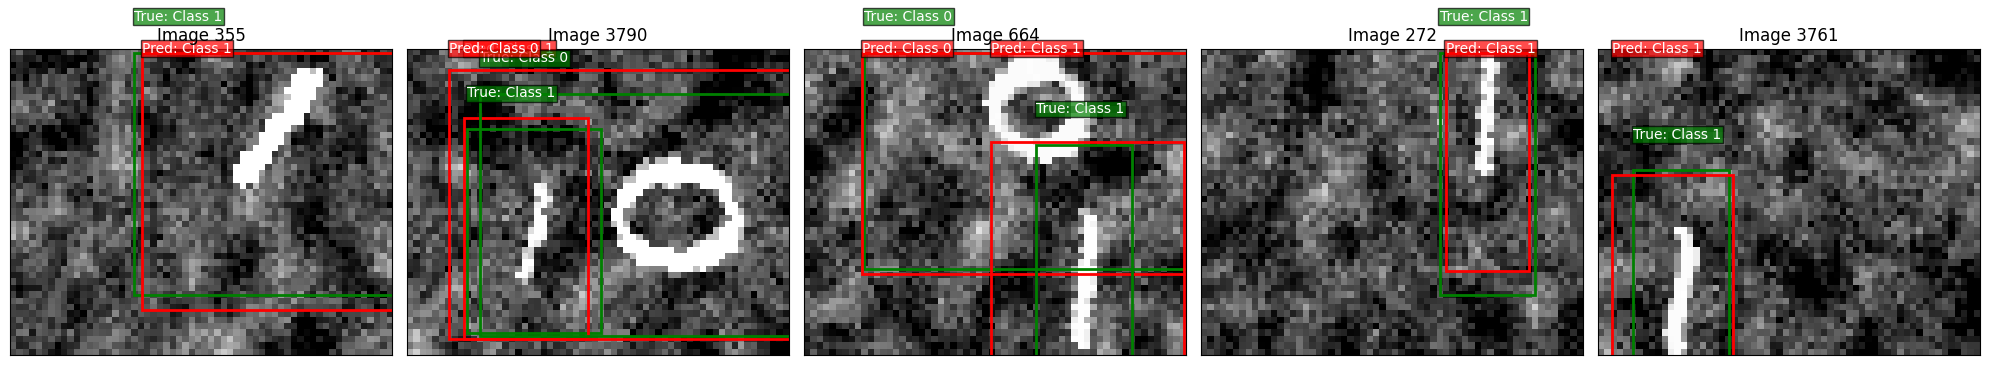

Finding best and worst predictions for best model...
Best predictions (best model):


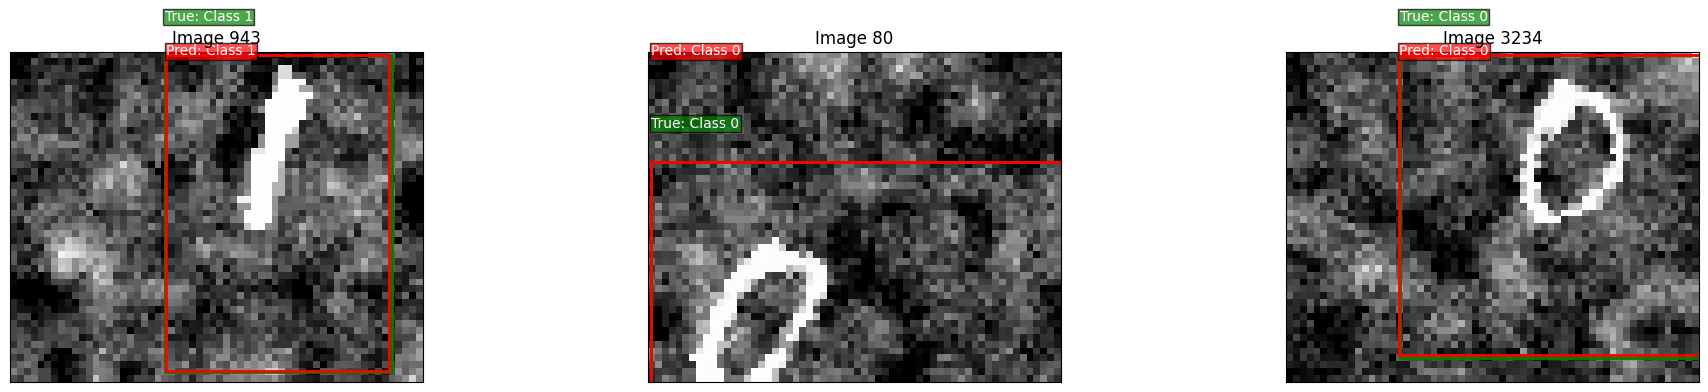

Worst predictions (best model):


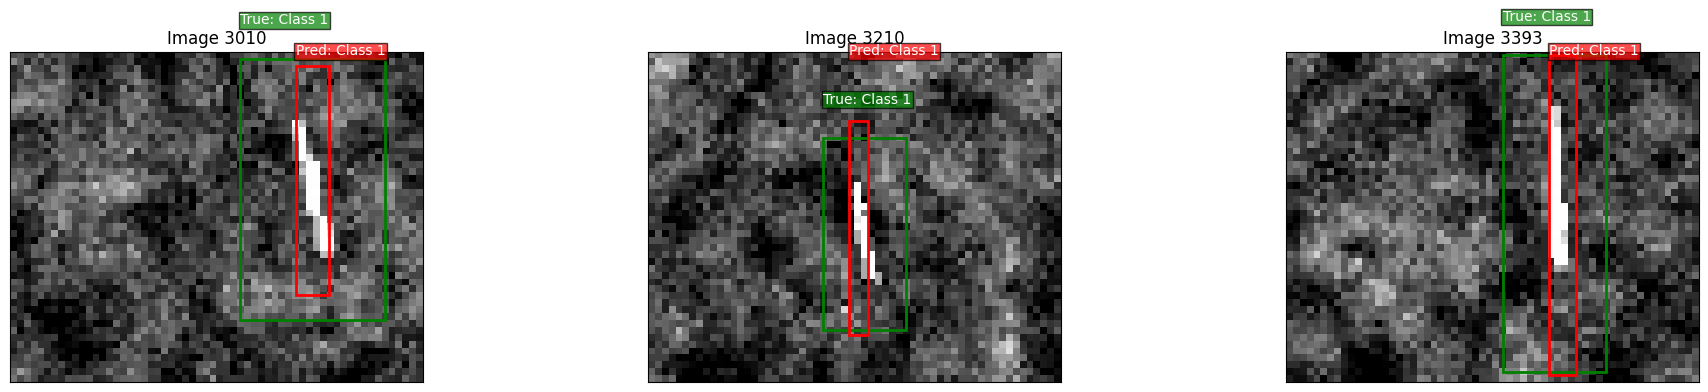

Finding best and worst predictions for improved model...
Best predictions (improved model):


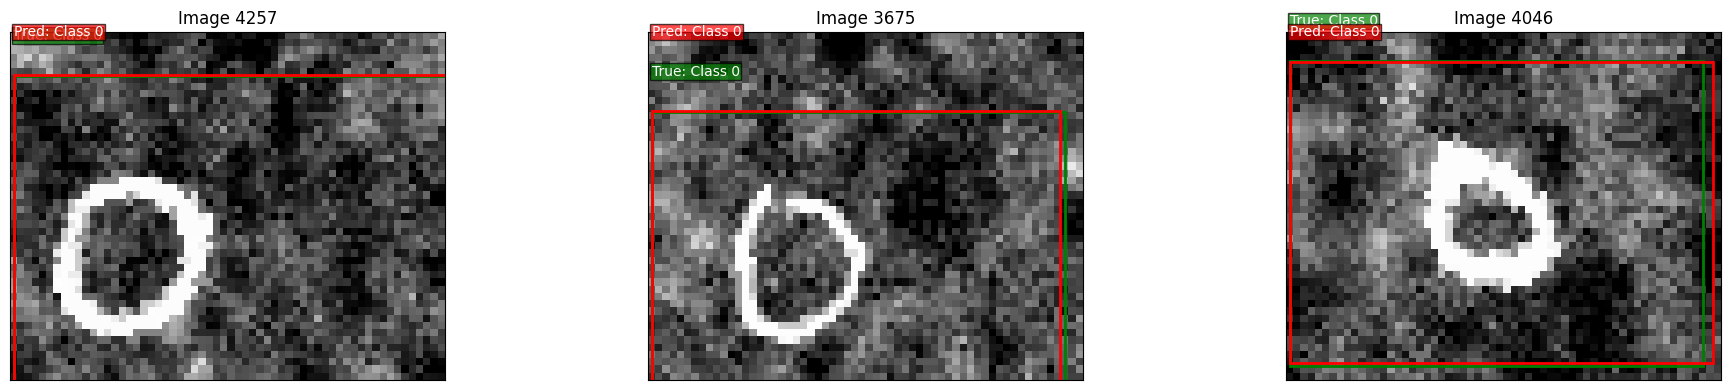

Worst predictions (improved model):


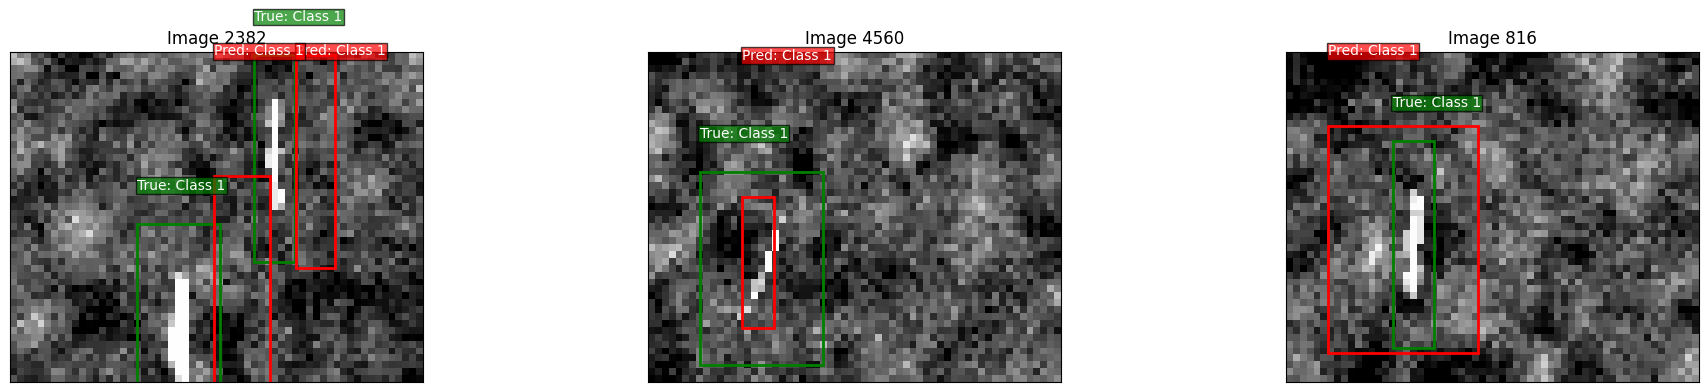

In [14]:
def visualize_bounding_boxes():
    """
    Demonstrate the bounding box visualization functions.
    """
    print("Visualizing random test samples with best model....")
    plot_images_with_bboxes(best_model, test_dataset, num_images=5)
    
    print("Finding best and worst predictions for best model...")
    best_indices, worst_indices = find_best_and_worst_predictions(best_model, test_dataset, n_samples=3)
    
    print("Best predictions (best model):")
    plot_images_with_bboxes(best_model, test_dataset, indices=best_indices)
    
    print("Worst predictions (best model):")
    plot_images_with_bboxes(best_model, test_dataset, indices=worst_indices)
    
    # If you want to see improved_model separately, you can retrieve it from the trained_models list
    improved_entry = next((x for x in trained_models if x["model_name"] == "ImprovedDetectNet"), None)
    if improved_entry is not None:
        improved_model = improved_entry["model"]
        print("Finding best and worst predictions for improved model...")
        best_indices_improved, worst_indices_improved = find_best_and_worst_predictions(improved_model, test_dataset, n_samples=3)
        print("Best predictions (improved model):")
        plot_images_with_bboxes(improved_model, test_dataset, indices=best_indices_improved)
        print("Worst predictions (improved model):")
        plot_images_with_bboxes(improved_model, test_dataset, indices=worst_indices_improved)
    else:
        print("ImprovedDetectNet was not trained.")

visualize_bounding_boxes()